# Exploring Celligner output

In [1]:
import celligner
import pandas as pd
import numpy as np
import re
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from taigapy import TaigaClient
tc = TaigaClient()

%load_ext autoreload
%autoreload 2

### Load Celligner model

In [2]:
my_celligner = celligner.Celligner()

In [4]:
my_celligner.load("../scratch/data/celligner/celligner-run_1_model_single.pkl")

In [5]:
fig = px.scatter(my_celligner.umap_reduced, x='umap1', y='umap2', color='tissue_type', symbol='cell_type', 
                 opacity=0.4, hover_data=['tissue_type'])

for i, trace in enumerate(fig.data):
    name = trace.name.split(',')
    if name[1] == ' CCLE cell line':
        trace['marker'] = dict(size=5, line=dict(width=0.5, color='DarkSlateGrey'), color=trace['marker']['color'])
        trace['showlegend'] = False
    else:
        trace['name'] = name[0]

fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle', color='black'),
                         name='TCGA tumor'))
fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle-open', color='black'),
                         name='Cell line'))

fig.update_layout(legend_title_text='', plot_bgcolor="white", height=600)
fig.update_xaxes(showticklabels=False); fig.update_yaxes(showticklabels=False)
fig.show()

### Model - tumor distances
Euclidean distances between tumor samples and cell line samples in the combined 70 principal components

In [9]:
# This is what is currently displayed in the public portal
prev_dist = tc.get(name='celligner-output-f163', version=27, file='tumor_CL_distances')

In [10]:
CCLE_annot = tc.get(name='internal-21q3-fe4c', version=16, file='sample_info')

In [11]:
new_dist = pd.merge(my_celligner.tumor_CL_dist.T.reset_index().rename(columns={'index':'DepMap_ID'}), 
                    CCLE_annot[['DepMap_ID','CCLE_Name']])\
              .set_index('CCLE_Name').drop(columns=['DepMap_ID']).T
new_dist = new_dist.loc[:, new_dist.columns.isin(prev_dist.columns)]
prev_dist = prev_dist.loc[:, prev_dist.columns.isin(new_dist.columns)]

Median correlation: 0.892


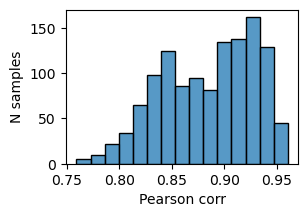

In [12]:
dist_corr = new_dist.corrwith(prev_dist)
print('Median correlation: %.3f' % (dist_corr.median()))
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(dist_corr, ax=ax); ax.set_xlabel('Pearson corr'); ax.set_ylabel('N samples');